# Spectral analysis of ECG signal using Python packages. 

Or use frequencies to get embeddings (use images of ECG)

- Fourier & Wavelet Spectrograms

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
from scipy.signal import resample
import torch
from transformers import AutoTokenizer, AutoModel
import ast
import scipy.io as sio
from scipy.signal import spectrogram
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
from PIL import Image
from torchvision.transforms import ToTensor

c:\Users\navme\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\navme\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\navme\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\navme\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
sys.path.append('C:/Users/navme/Desktop/ECG_Project/PyFiles')

In [3]:
from helper_functions import *

In [4]:
PhysioNet_PATH = f'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training'
PhysioNet_PATH

'C:/Users/navme/Desktop/ECG_Thesis_Local/PhysioNet-2021-Challenge/physionet.org/files/challenge-2021/1.0.3/training'

In [9]:
smowmed_mappings_path = 'C:/Users/navme/Desktop/ECG_Project/Data/SNOWMED-CT Codes/combined_mappings.csv'

# Load the SNOMED-CT mappings
smowmed_mappings = pd.read_csv(smowmed_mappings_path)
smowmed_mappings.head(2)

,Dx,SNOMEDCTCode,Abbreviation,CPSC,CPSC_Extra,StPetersburg,PTB,PTB_XL,Georgia,Chapman_Shaoxing,Ningbo,Total,Notes
0,atrial fibrillation,164889003,AF,1221,153,2,15,1514,570,1780,0,5255,NaN
1,atrial flutter,164890007,AFL,0,54,0,1,73,186,445,7615,8374,NaN


In [10]:
# Select the 'Dx' and 'SNOMEDCTCode' columns
codes = smowmed_mappings[['Dx', 'SNOMEDCTCode']]

# Set 'SNOWMEDCTCode' as the index
codes.set_index('SNOMEDCTCode', inplace=True)

# Convert the DataFrame into a dictionary
codes_dict = codes['Dx'].to_dict()

In [11]:
list(codes_dict.items())[:5]

[(164889003, 'atrial fibrillation'),
 (164890007, 'atrial flutter'),
 (6374002, 'bundle branch block'),
 (426627000, 'bradycardia'),
 (733534002, 'complete left bundle branch block')]

In [12]:
class PhysioNetDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=False):
        self.dataset_path = dataset_path
        self.dataset_path = [path for path in self.dataset_path if "index.html" not in path]
        self.train = train
        self.file_list = os.listdir(dataset_path)
        self._hea_files = []
        self._mat_files = []
        self._indices_files = []
        self._hea_files_path = []
        self._mat_files_path = []

        self.file_PATHS = []  # Directory to main database folders
        self.data_files = []  # Directory to data files

        # Validation Case: PTB Databases only
        if self.train == False:
            validation_datasets = ['ptb', 'ptb-xl']
            for file in os.listdir(dataset_path):
                if file in validation_datasets:
                    file_path = os.path.join(dataset_path, file)
                    file_path = file_path.replace('\\', '/')
                    self.file_PATHS.append(file_path)

        # Training Case: All Databases excluding PTB
        else:
            validation_datasets = ['ptb', 'ptb-xl']
            for file in os.listdir(dataset_path):
                if file not in validation_datasets:
                    file_path = os.path.join(dataset_path, file)
                    file_path = file_path.replace('\\', '/')
                    self.file_PATHS.append(file_path)

        for path in self.file_PATHS:
            if os.path.isdir(path):
                for sub_folder in os.listdir(path):
                    sub_folder_path = os.path.join(path, sub_folder)
                    sub_folder_path = sub_folder_path.replace('\\', '/')

                    # Ignore index.html files
                    if sub_folder_path.endswith('index.html'):
                        self._indices_files.append(sub_folder_path)
                    else:
                        if os.path.isdir(sub_folder_path):
                            for file in os.listdir(sub_folder_path):
                                # Get all .hea files
                                if file.endswith('.hea'):
                                    file_path = os.path.join(sub_folder_path, file)
                                    file_path = file_path.replace('\\', '/')
                                    self._hea_files.append(file_path)
                                    self._hea_files_path.append(file_path)
                                # Get all .mat files
                                elif file.endswith('.mat'):
                                    file_path = os.path.join(sub_folder_path, file)
                                    file_path = file_path.replace('\\', '/')
                                    self._mat_files.append(file_path)
                                    self._mat_files_path.append(file_path)

    def resample_ecg(self, ecg, new_length=1280):
        # Get the current length of the ECG
        current_length = ecg.shape[1]

        # Resample the ECG
        resampled_ecg = resample(ecg, new_length, axis=1)

        return resampled_ecg

    def __getitem__(self, index):
        if isinstance(index, slice):
            start, stop, step = index.indices(len(self))
            return [self[i] for i in range(start, stop, step)]
        # 1. Get .hea file
        hea_file_path = self._hea_files[index]
        with open(hea_file_path, 'r') as f:
            lines = f.readlines()

        dx_modalities = None
        # Parse header information
        for line in lines:
            if line.startswith('# Dx:'):
                dx_codes = line.split(':')[1].strip().split(',')
                dx_modalities = [codes_dict.get(int(code.strip()), code.strip()) for code in dx_codes]

        # 2. Get .mat file
        twelve_lead_ecg = None
        if index < len(self._mat_files):
            mat_file_path = self._mat_files[index]
            mat_data = sio.loadmat(mat_file_path)

            # Extract the ECG data
            twelve_lead_ecg = mat_data['val']

            # Resample the ECG if it is not None
            twelve_lead_ecg = self.resample_ecg(twelve_lead_ecg)

        else:
            print(f"MAT file for index {index} does not exist.")

        # Return list of diagnoses and the np array of the 12-lead ECG
        return dx_modalities, twelve_lead_ecg

    def plot_record(self, index):
        mat_file_path = self._mat_files[index]
        data = sio.loadmat(mat_file_path)

        # Resample the ECG data
        resampled_data = self.resample_ecg(data['val'])

        fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

        for i, ax in enumerate(axs.flat):
            ax.plot(resampled_data[i], linewidth=0.5)
            ax.set_xlabel('Sample')
            ax.set_ylabel('Amplitude')
            ax.set_title(f'Lead {i+1}')

        plt.tight_layout()
        plt.show()

    def __len__(self):
        return len(self._hea_files)

In [13]:
expA_dataset = PhysioNetDataset(PhysioNet_PATH, train=False)
len(expA_dataset)  # Should be 22353 records in total

22352

In [14]:
train_set[0][1]

array([[-1.47934506e+02, -2.91551642e+02, -2.74809429e+02, ...,
         4.77644753e+01,  2.01384661e+01, -1.00679359e+01],
       [ 1.52465921e+02,  2.77678555e+02,  1.56586784e+02, ...,
        -1.76658954e+01, -7.90760175e-01, -8.52215162e+01],
       [ 2.99599534e+02,  5.69111328e+02,  4.31794817e+02, ...,
        -6.55007739e+01, -2.09576266e+01, -7.49694829e+01],
       ...,
       [ 4.45112902e+02,  8.51659816e+02,  4.92258244e+02, ...,
        -1.80126454e+02, -1.07239566e+02, -2.77821297e+02],
       [ 4.47370607e+02,  8.51337442e+02,  4.91900225e+02, ...,
        -1.72717314e+02, -1.11531345e+02, -2.75650939e+02],
       [ 3.63444041e+02,  5.66276390e+02,  3.74951126e+02, ...,
         9.15587806e+01,  1.49537284e+02,  8.07816050e+01]])

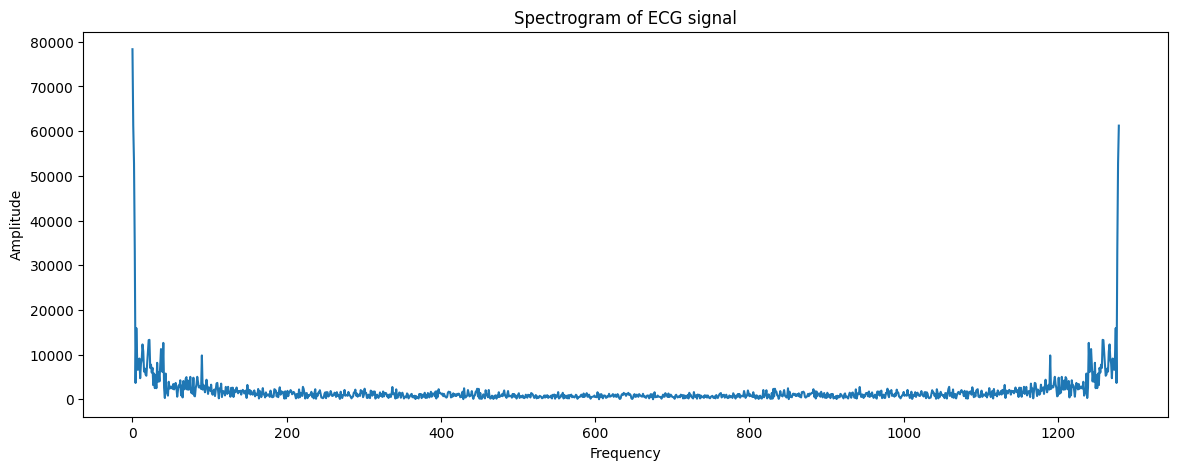

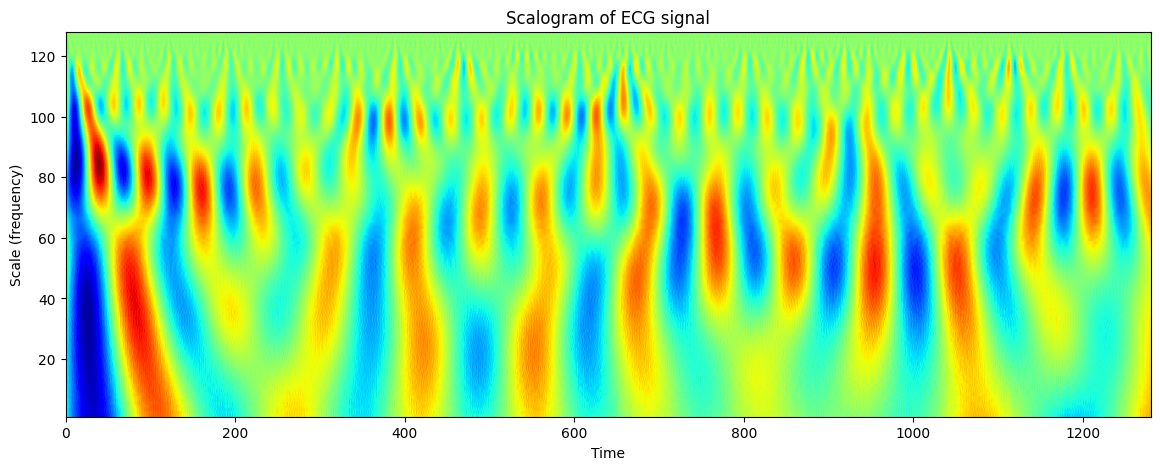

In [16]:
import matplotlib.pyplot as plt
from scipy.fft import fft
import pywt

# 1. Extract ECG signal
# Assuming the 'val' is your ECG signal and selecting the first lead
index = 0  # change this to choose different signals
ecg_data = train_set[index][1]
ecg_signal = ecg_data[0]  # selecting the first lead

# 2. Apply Fourier Transform
ecg_fft = fft(ecg_signal)

# 3. Visualize Fourier Transform (Spectrogram)
plt.figure(figsize=(14, 5))
plt.plot(np.abs(ecg_fft))
plt.title('Spectrogram of ECG signal')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

# 4. Apply Wavelet Transform
waveletname = 'morl'
coeffs, freqs = pywt.cwt(ecg_signal, np.arange(1, 128), waveletname)

# 5. Visualize Wavelet Transform (Scalogram)
plt.figure(figsize=(14, 5))
plt.imshow(coeffs, aspect='auto', cmap='jet', 
           extent=[0, len(ecg_signal), 1, 128])
plt.title('Scalogram of ECG signal')
plt.xlabel('Time')
plt.ylabel('Scale (frequency)')
plt.show()

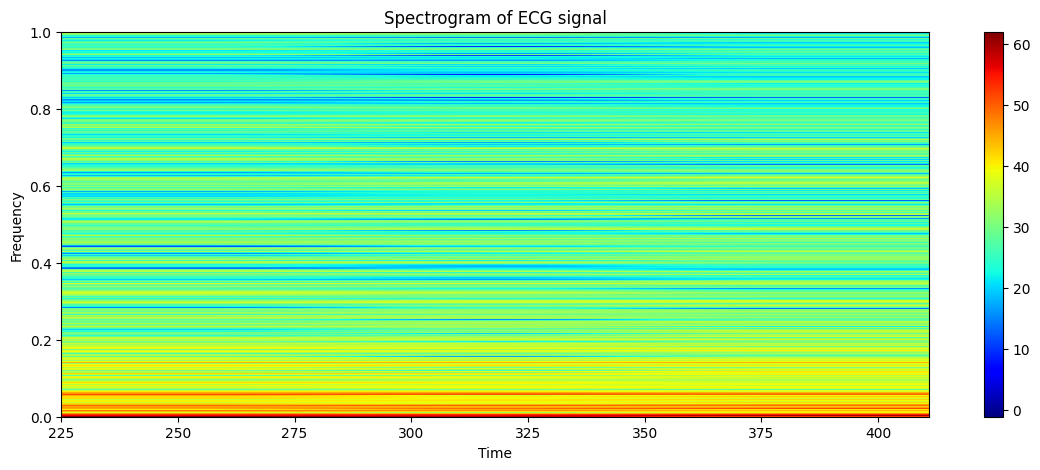

In [17]:
# 6. Apply Fourier Transform and plot spectrogram
plt.figure(figsize=(14, 5))
Pxx, freqs, bins, im = plt.specgram(ecg_signal, NFFT=1024, Fs=2, noverlap=900, cmap='jet')
plt.title('Spectrogram of ECG signal')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()

# Save the figure as an image
plt.savefig('spectrogram_example.png', dpi=300, bbox_inches='tight')

plt.show()

# ECGSpectrogramGenerator()

In [18]:
import scipy.io as sio

class ECGSpectrogramGenerator:
    def __init__(self, save_dir):
        self.save_dir = save_dir

    def generate_spectrogram(self, mat_file, recording_number):
        # Load the ECG signal from the .mat file
        ecg_signal = sio.loadmat(mat_file)['val']

        # Generate a spectrogram for each lead
        for lead_id, lead_signal in enumerate(ecg_signal):
            plt.figure(figsize=(14, 5))
            Pxx, freqs, bins, im = plt.specgram(lead_signal, NFFT=1024, Fs=2, noverlap=900, cmap='jet')
            plt.title(f'Spectrogram of ECG signal {recording_number}, lead {lead_id}')
            plt.xlabel('Time')
            plt.ylabel('Frequency')
            plt.colorbar()

            # Save the figure as an image
            plt.savefig(os.path.join(self.save_dir, f'spectrogram_{recording_number}_lead_{lead_id}.png'), dpi=300, bbox_inches='tight')
            plt.close()

In [19]:
ecg_spectrogram_generator = ECGSpectrogramGenerator('C:/Users/navme/Desktop/ECG_Project/Spectrograms')

In [20]:
for i in range(1):  # only process the first record. There should be 12 spectrogram images, one for each lead
    mat_file = train_set._mat_files[i]
    recording_number = i  # or replace with actual recording number if available
    ecg_spectrogram_generator.generate_spectrogram(mat_file, recording_number)